<a href="https://colab.research.google.com/github/lzocro/-Papers/blob/master/DL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning assignment 1

## Definitions

In [0]:

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

###Keras stuff
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, advanced_activations, Flatten, Conv2D, MaxPooling2D, Flatten, Input, UpSampling2D, merge
from keras.utils import np_utils
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import regularizers
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

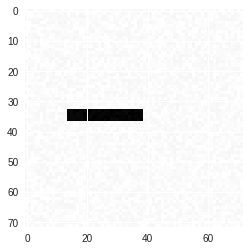

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

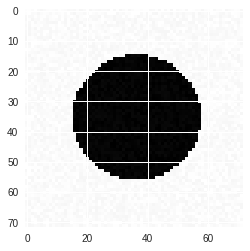

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

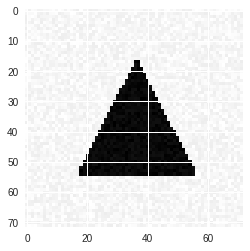

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [0]:
import matplotlib.patches as patches

def visualize_prediction(x, y, nr, nc):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=nc)
    index=0
    for i in range(nr):
        for j in range(nc):
            I = x[index].reshape((IMAGE_SIZE,IMAGE_SIZE))
            axarr[i,j].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
            axarr[i,j].set_xlim([0,1])
            axarr[i,j].set_ylim([0,1])
            axarr[i,j].grid(False)
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            xy = y[index].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
            axarr[i,j].add_patch(tri)
            index+=1
    #return(ax)
    plt.show()

## A Simple Classification Task


Here we generate some data.

In [7]:
[X_train, Y_train] = generate_dataset_classification(400, 20)
Y_train=np_utils.to_categorical(Y_train,3)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)

Creating data:


A simple perceptron with SGD appears to never reach the optimum value, and often gets stuck in a local minimum of around two thirds accuracy. This was consistent regardless of the number of neurons, and the loss chosen. Although 16 neurons and binary corssentropy yielded the best results. 

In [8]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape =(72,72,1)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
sgd=SGD(lr=0.01,decay=1e-6,momentum=0.9,nesterov=True)
model.compile(loss='binary_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.fit(X_train,Y_train, batch_size=32,validation_split=0.25,epochs=10,verbose=1)

Train on 300 samples, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 1s 3ms/step - loss: 1.0818 - acc: 0.6289 - val_loss: 0.6365 - val_acc: 0.6667
Epoch 2/10
300/300 [==============================] - 0s 411us/step - loss: 0.6364 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667
Epoch 3/10
300/300 [==============================] - 0s 413us/step - loss: 0.6360 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667
Epoch 4/10
300/300 [==============================] - 0s 424us/step - loss: 0.6359 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667
Epoch 5/10
300/300 [==============================] - 0s 409us/step - loss: 0.6359 - acc: 0.6667 - val_loss: 0.6364 - val_acc: 0.6667
Epoch 6/10
300/300 [==============================] - 0s 435us/step - loss: 0.6358 - acc: 0.6667 - val_loss: 0.6365 - val_acc: 0.6667
Epoch 7/10
300/300 [==============================] - 0s 423us/step - loss: 0.6358 - acc: 0.6667 - val_loss: 0.6366 - val_acc: 0.6667
Epoch 8/10
300/300

The best model to come out of our experiments is the following one, a 2 layer perceptron, with 16 input neurons, with rectified linear units activation and a binary crossentropy target with the Adam optimiser. It consistently reaches 0.75 accuracy and was recorded at a maximum of 0.9967 after 20 epochs with 32 samples per batch.  Adam. yielded better results overall, and will be used throughout, unless adadelta is used for larger networks.

In [9]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape =(72,72,1)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(X_train,Y_train,batch_size=32,validation_split=0.06,epochs=20,verbose=1)

Train on 376 samples, validate on 24 samples
Epoch 1/20
376/376 [==============================] - 0s 1ms/step - loss: 1.1158 - acc: 0.5913 - val_loss: 0.7248 - val_acc: 0.6944
Epoch 2/20
376/376 [==============================] - 0s 381us/step - loss: 0.4503 - acc: 0.7988 - val_loss: 0.2428 - val_acc: 0.9444
Epoch 3/20
376/376 [==============================] - 0s 406us/step - loss: 0.2823 - acc: 0.8759 - val_loss: 0.2105 - val_acc: 0.9167
Epoch 4/20
376/376 [==============================] - 0s 402us/step - loss: 0.2410 - acc: 0.8972 - val_loss: 0.1489 - val_acc: 0.9722
Epoch 5/20
376/376 [==============================] - 0s 403us/step - loss: 0.2001 - acc: 0.9158 - val_loss: 0.1323 - val_acc: 0.9444
Epoch 6/20
376/376 [==============================] - 0s 404us/step - loss: 0.1896 - acc: 0.9211 - val_loss: 0.1388 - val_acc: 0.9167
Epoch 7/20
376/376 [==============================] - 0s 391us/step - loss: 0.1562 - acc: 0.9415 - val_loss: 0.0741 - val_acc: 1.0000
Epoch 8/20
376/376 

In [10]:
X_test = generate_a_disk()
X_test = X_test.reshape(1,72,72,1)
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

The Weights did not appear to show any interesting features. 

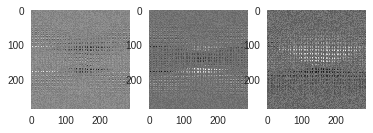

In [11]:
weights=model.get_weights()

#print(weights)
fig,(ax1,ax2,ax3)=plt.subplots(nrows=1,ncols=3)
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax1.imshow(weights[2].reshape((288,288,3))[:,:,0],cmap='gray')
ax2.imshow(weights[2].reshape((288,288,3))[:,:,1],cmap='gray')
ax3.imshow(weights[2].reshape((288,288,3))[:,:,2],cmap='gray')
plt.show()

## A More Complex Classification Task


### Simple Model

First we generate a large dataset, with noise and movement.

In [12]:
#simpleClassifierComplexTask
[X_train, Y_train] = generate_dataset_classification(3000, 20, True)
Y_train=np_utils.to_categorical(Y_train,3)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)

Creating data:


Now we train our previous classifier (the second one from part 1.2) on this data. Training accuracy is correct, around 0.75.

In [13]:
#simpleClassifierComplexTaskRun =>simpleClassifierComplexTask
model.fit(X_train,Y_train,batch_size=32,validation_split=0.1,epochs=20,verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/20
2700/2700 [==============================] - 1s 432us/step - loss: 0.8789 - acc: 0.6441 - val_loss: 0.6646 - val_acc: 0.6378
Epoch 2/20
2700/2700 [==============================] - 1s 413us/step - loss: 0.5570 - acc: 0.7084 - val_loss: 0.5641 - val_acc: 0.7111
Epoch 3/20
2700/2700 [==============================] - 1s 408us/step - loss: 0.5231 - acc: 0.7323 - val_loss: 0.5283 - val_acc: 0.6989
Epoch 4/20
2700/2700 [==============================] - 1s 393us/step - loss: 0.4946 - acc: 0.7448 - val_loss: 0.5096 - val_acc: 0.7322
Epoch 5/20
2700/2700 [==============================] - 1s 378us/step - loss: 0.4845 - acc: 0.7496 - val_loss: 0.4808 - val_acc: 0.7144
Epoch 6/20
2700/2700 [==============================] - 1s 396us/step - loss: 0.4946 - acc: 0.7428 - val_loss: 0.4932 - val_acc: 0.7189
Epoch 7/20
2700/2700 [==============================] - 1s 448us/step - loss: 0.4872 - acc: 0.7514 - val_loss: 0.4876 - val_acc: 0.7467
E

Moving on to testing data, we note a performance very comparable to the one in the training dataset, around 0.75.

In [14]:
[X_test, Y_test] = generate_test_set_classification()
#Y_test=np_utils.to_categorical(Y_test,3) already done by the function
X_test=X_test.reshape((X_test.shape[0],72,72))
X_test=np.expand_dims(X_test, axis=-1)

Creating data:


In [15]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 163us/step


[0.5028029330571493, 0.7533333547910055]

### A Convolutional Neural Network classifier


#### Convolutional network 1 


A simple convolutional network composed of 1 convolutional layer with 16 5×5 filters, 1 pooling layer, and one fully connected layer. optimising binary corssentropy with sgd gives training accuracy around 0.9 after 10 epochs, which rises to 0.97 after 20, but this does not propagate to the test set, indicating over-fitting.  

In [16]:
model=Sequential()
########
model.add(Conv2D(16, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(3,activation='softmax'))
########
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
########
model.fit(X_train, Y_train, batch_size=32,validation_split=0.1, epochs=100, verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 2s 712us/step - loss: 0.5937 - acc: 0.6909 - val_loss: 0.4960 - val_acc: 0.7500
Epoch 2/100
2700/2700 [==============================] - 1s 360us/step - loss: 0.4656 - acc: 0.7701 - val_loss: 0.4226 - val_acc: 0.7800
Epoch 3/100
2700/2700 [==============================] - 1s 363us/step - loss: 0.4054 - acc: 0.8017 - val_loss: 0.4232 - val_acc: 0.7811
Epoch 4/100
2700/2700 [==============================] - 1s 368us/step - loss: 0.3734 - acc: 0.8193 - val_loss: 0.3837 - val_acc: 0.7933
Epoch 5/100
2700/2700 [==============================] - 1s 364us/step - loss: 0.3380 - acc: 0.8516 - val_loss: 0.3653 - val_acc: 0.7956
Epoch 6/100
2700/2700 [==============================] - 1s 368us/step - loss: 0.2958 - acc: 0.8806 - val_loss: 0.3084 - val_acc: 0.8767
Epoch 7/100
2700/2700 [==============================] - 1s 367us/step - loss: 0.2678 - acc: 0.8922 - val_loss: 0.2873 - val_acc: 0

One can observe the test values stay around 0.97.

In [17]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 174us/step


[0.20227456400791805, 0.945555571715037]

#### Convolutional network 2


Let's attempt to use a heavier network to improve the scores. We take a Convolution layer with 32 5x5 filters, maxpooling and dropout, a dense hidden layer with 128 neurons and Adam as our optimizer for binary crossentropy. This yields sizeable improvements, but at a large training time cost. Validation and test accuracy is also around 0.95. 

In [18]:
model=Sequential()
########
model.add(Conv2D(32, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(3,activation='softmax'))
########
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
########
History = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, verbose=1)

Train on 2700 samples, validate on 300 samples
Epoch 1/100
2700/2700 [==============================] - 2s 875us/step - loss: 0.6841 - acc: 0.7225 - val_loss: 0.3890 - val_acc: 0.8200
Epoch 2/100
2700/2700 [==============================] - 2s 572us/step - loss: 0.3831 - acc: 0.8251 - val_loss: 0.3334 - val_acc: 0.8678
Epoch 3/100
2700/2700 [==============================] - 2s 569us/step - loss: 0.3258 - acc: 0.8630 - val_loss: 0.3011 - val_acc: 0.8589
Epoch 4/100
2700/2700 [==============================] - 2s 570us/step - loss: 0.2500 - acc: 0.9067 - val_loss: 0.2107 - val_acc: 0.9389
Epoch 5/100
2700/2700 [==============================] - 2s 569us/step - loss: 0.2059 - acc: 0.9257 - val_loss: 0.1873 - val_acc: 0.9489
Epoch 6/100
2700/2700 [==============================] - 2s 572us/step - loss: 0.1670 - acc: 0.9447 - val_loss: 0.1535 - val_acc: 0.9378
Epoch 7/100
2700/2700 [==============================] - 2s 572us/step - loss: 0.1452 - acc: 0.9521 - val_loss: 0.1359 - val_acc: 0

In [19]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 166us/step


[0.2803726812203725, 0.9466666913032532]

The following plot presents a clear illustration of the learning quality of our network.

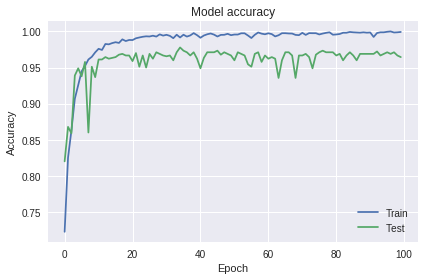

In [20]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
#ax.grid(True,which='both',ls=':',color='Gainsboro')
########
ax.plot(History.history['acc'], marker='', label="Train")
ax.plot(History.history['val_acc'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Accuracy')
ax.set_title(r'Model accuracy')# ($C(p)=$ {}, {} Simulations)'.format(round(KLBern(MAB),3),Sim))
#plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
fig.tight_layout()
plt.show()
########

## Regression on the vertices of the triangle

#### A First attempt network

We begin with some data generation.

In [21]:
[X_train,Y_train]=generate_dataset_regression(3000,20)
X_train=X_train.reshape((X_train.shape[0],72,72))
X_train=np.expand_dims(X_train, axis=-1)
print(X_train.shape,Y_train.shape)

Creating data:
(3000, 72, 72, 1) (3000, 6)


Here we turn the data into a vectors of length 6 made of 3 tuples (the vertices) sorted by their first component. This normalisation should make the labelling of each triangle unique, and no longer invariant under permutation as it is if we only predict where the summits are. 

In [0]:
def Ysort(Y):
    for y in range(Y.shape[0]):
        y1=Y[y][0:2]
        y2=Y[y][2:4]
        y3=Y[y][4:6]
        Y[y]=[element for tupl in sorted([y1,y2,y3], key=lambda x: x[0]) for element in tupl]
    return(Y)

Y_train=Ysort(Y_train)

We begin by repurposing the network from the previous question for use with this regression task, using a large dataset. The results are disapointing with a normal learning rate, but they were encouraging with one of the order $10^{-3}$ so we attempt to lower it even more and simply stack large amounts of epochs. The results are encouraging.

In [23]:
model=Sequential()
########
model.add(Conv2D(32, (5,5), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
########
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
########
model.add(Dense(6,activation='relu'))
########
adam=Adam(0.0005)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])
########
History = model.fit(X_train, Y_train, validation_split=0.03, batch_size=32, epochs=500, verbose=1)

Train on 2910 samples, validate on 90 samples
Epoch 1/500
2910/2910 [==============================] - 2s 756us/step - loss: 0.3167 - mean_absolute_error: 0.4186 - val_loss: 0.2069 - val_mean_absolute_error: 0.3756
Epoch 2/500
2910/2910 [==============================] - 2s 524us/step - loss: 0.1970 - mean_absolute_error: 0.3608 - val_loss: 0.1820 - val_mean_absolute_error: 0.3555
Epoch 3/500
2910/2910 [==============================] - 2s 518us/step - loss: 0.1553 - mean_absolute_error: 0.3122 - val_loss: 0.1073 - val_mean_absolute_error: 0.2692
Epoch 4/500
2910/2910 [==============================] - 2s 521us/step - loss: 0.1339 - mean_absolute_error: 0.2892 - val_loss: 0.0703 - val_mean_absolute_error: 0.2216
Epoch 5/500
2910/2910 [==============================] - 2s 527us/step - loss: 0.1129 - mean_absolute_error: 0.2648 - val_loss: 0.0842 - val_mean_absolute_error: 0.2409
Epoch 6/500
2910/2910 [==============================] - 2s 551us/step - loss: 0.1006 - mean_absolute_error: 

In [24]:
[X_test, Y_test] = generate_test_set_regression()
X_test=X_test.reshape((X_test.shape[0],72,72))
X_test=np.expand_dims(X_test, axis=-1)
Y_test=Ysort(Y_test)

Creating data:


In [25]:
model.evaluate(X_test, Y_test,verbose=1)

300/300 [==============================] - 0s 189us/step


[0.010599367196361224, 0.0698986546198527]

Plotting convergence we observe interesting "phase" behaviour, and we appear to have moved outside the regime where this occurs, and our model barely improves its validation loss after 100 epochs, although it does not seem to suffer from overfitting even when its training continues, the validation loss stays constant.

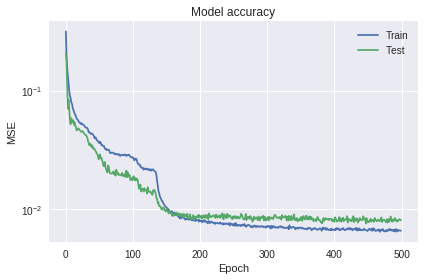

In [26]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
#ax.grid(True,which='both',ls=':',color='Gainsboro')
########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'MSE')
ax.set_yscale('log')
ax.set_title(r'Model accuracy')# ($C(p)=$ {}, {} Simulations)'.format(round(KLBern(MAB),3),Sim))
#plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
fig.tight_layout()
plt.show()

This is what training predictions look like, not bad at all. 

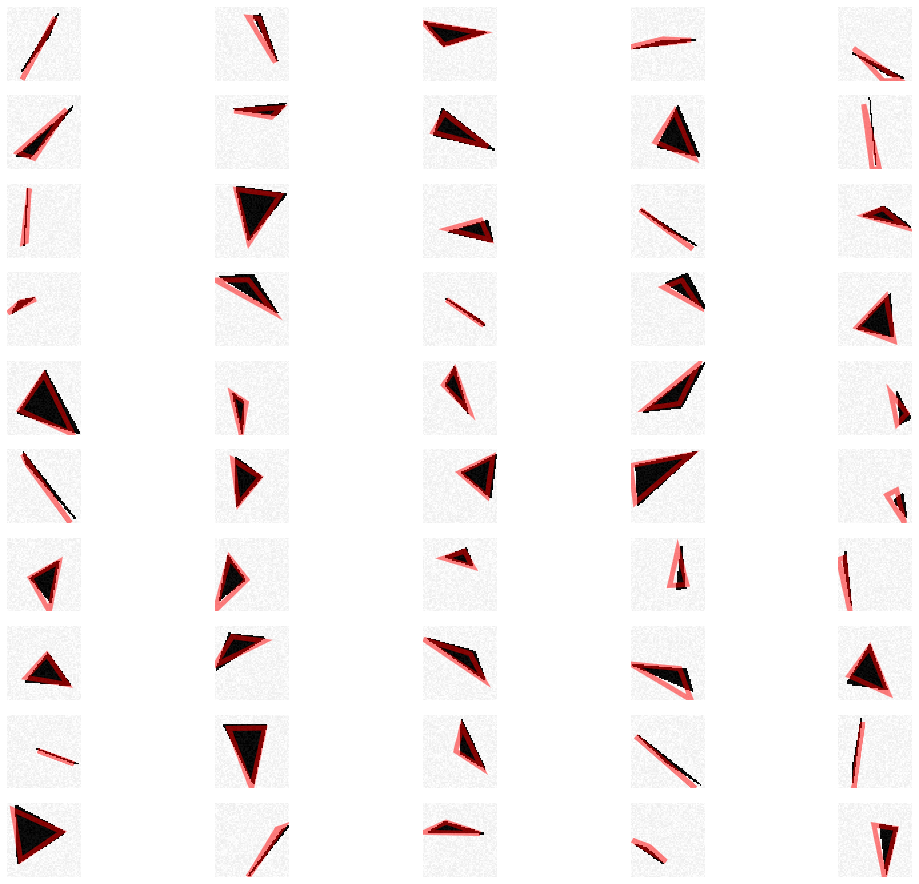

In [27]:
Y_pred=model.predict(X_train)
visualize_prediction(X_train[0:51], Y_pred[0:51],nr=10,nc=5)

These are the results on a test set. Slightly less impressive when it comes to larger triangles.

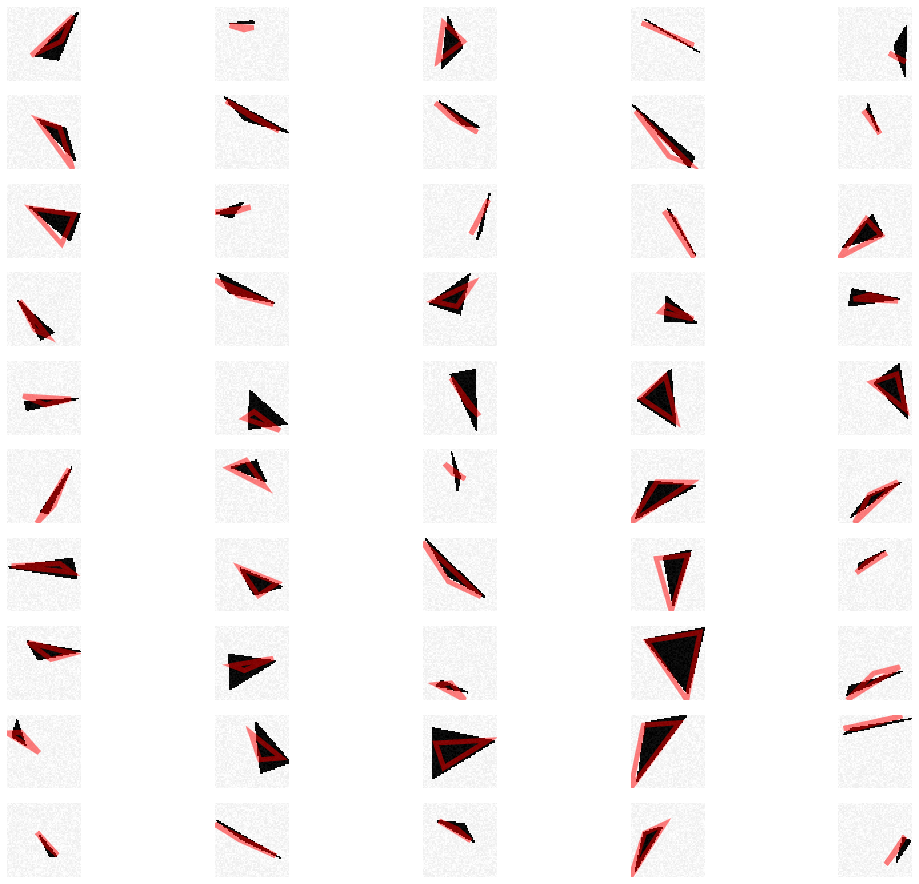

In [28]:
Y_pred=model.predict(X_test)
visualize_prediction(X_test[0:51], Y_pred[0:51],nr=10,nc=5)

#### A second attempt network

The previous network faired well but it still fails to appropriately identify larger triangles in the test set, perhaps this can be resolved by stacking several convolution layers, so that the network can reason at larger scales from aggregated filters. We keep our slow learning rate adam from the previous network.

In [29]:
model=Sequential()
########
model.add(Conv2D(64, (3,3), activation='relu', input_shape =(72,72,1)))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
########
model.add(Conv2D(32, (3,3), activation='relu',))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
########
model.add(Conv2D(32, (3,3), activation='relu',))
########
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
########
model.add(Conv2D(16, (3,3), activation='relu',))
########
model.add(Flatten())
model.add(Dense(6))
########
model.compile(loss='mean_squared_error', optimizer=adam)
########
History = model.fit(X_train, Y_train, validation_split=0.03, batch_size=32, epochs=500, verbose=1)

Train on 2910 samples, validate on 90 samples
Epoch 1/500
2910/2910 [==============================] - 3s 975us/step - loss: 0.0655 - val_loss: 0.0434
Epoch 2/500
2910/2910 [==============================] - 2s 686us/step - loss: 0.0344 - val_loss: 0.0321
Epoch 3/500
2910/2910 [==============================] - 2s 681us/step - loss: 0.0270 - val_loss: 0.0282
Epoch 4/500
2910/2910 [==============================] - 2s 683us/step - loss: 0.0222 - val_loss: 0.0199
Epoch 5/500
2910/2910 [==============================] - 2s 687us/step - loss: 0.0186 - val_loss: 0.0160
Epoch 6/500
2910/2910 [==============================] - 2s 685us/step - loss: 0.0164 - val_loss: 0.0141
Epoch 7/500
2910/2910 [==============================] - 2s 689us/step - loss: 0.0143 - val_loss: 0.0118
Epoch 8/500
2910/2910 [==============================] - 2s 684us/step - loss: 0.0133 - val_loss: 0.0121
Epoch 9/500
2910/2910 [==============================] - 2s 686us/step - loss: 0.0122 - val_loss: 0.0103
Epoch 10/

Plotting the convergeance, we can see a very different behaviour from in the previous model, but it slowly increases in quality after the initial 100 epochs. 

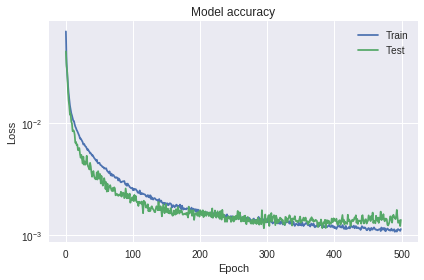

In [30]:
fig,ax=plt.subplots()
ax.set_axisbelow(True)
#ax.grid(True,which='both',ls=':',color='Gainsboro')
########
ax.plot(History.history['loss'], marker='', label="Train")
ax.plot(History.history['val_loss'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_yscale('log')
ax.set_title(r'Model accuracy')# ($C(p)=$ {}, {} Simulations)'.format(round(KLBern(MAB),3),Sim))
#plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
fig.tight_layout()
plt.show()
########

Evaluating on the trian set shows the network has near-flawlessly learnt to understant its training data.

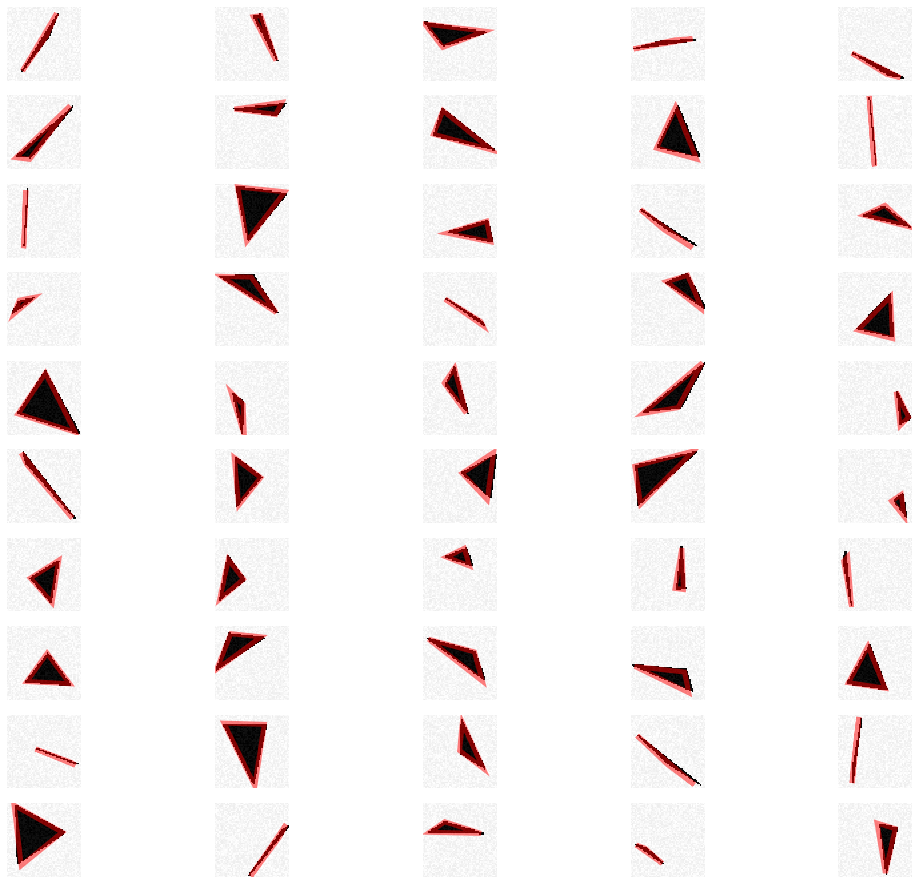

In [31]:
Y_pred=model.predict(X_train)
visualize_prediction(X_train[0:51], Y_pred[0:51],nr=10,nc=5)


On the test set we can see very good performance, although the return on investment for the increased complexity isn't very large. 

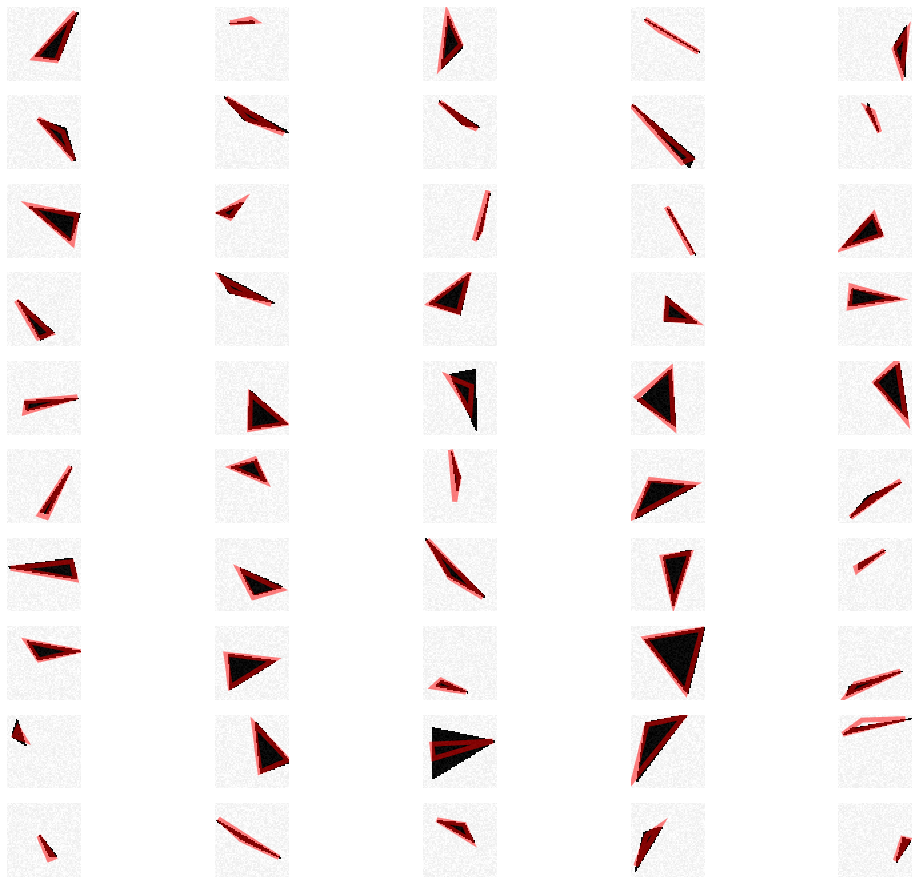

In [32]:
Y_pred=model.predict(X_test)
visualize_prediction(X_test[0:51], Y_pred[0:51],nr=10,nc=5)

## Image Denoising

### A first network

We begin by modifying the required generation functions.

In [0]:
def generate_a_rectangle_star(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_disk_star(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]

def generate_a_triangle_star(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [generate_a_drawing(figsize, U, V, noise),generate_a_drawing(figsize, U, V, 0.0)]

def generate_dataset_denoising(nb_samples, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise=np.random.uniform(0.0,30.0)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_star(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_star(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_star(noise, free_location)
    return [X, Y]

def visualise_denoising(x, y, nr):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=4)
    index=0
    for i in range(nr):
       # for j in range(4):
        axarr[i,0].imshow(x[index])
        axarr[i,1].imshow(y[index])
        index+=1
        axarr[i,2].imshow(x[index])
        axarr[i,3].imshow(y[index])
        index+=1
    plt.show()

Now we generate some data with our new functions. 

In [14]:
n=5000
X_train2, Y_train2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_train2 = X_train2.reshape((n,72,72,1))
Y_train2 = Y_train2.reshape((n,72,72,1))                      


Creating data:


We try a simple network first, with only one down sampling, keeping our slow learning adam and with a bianry_cross entropy loss. 

In [22]:
#shallow, wide #tends to work best
model2 = Sequential()
########
model2.add(Conv2D(32, (3,3), activation='relu', input_shape=(72,72,1),padding='same',kernel_regularizer=regularizers.l2(0.00001),activity_regularizer=regularizers.l1(0.00001)))
model2.add(MaxPooling2D((2,2), padding="same")) #36*36
########
model2.add(Conv2D(32,(3,3),padding='same',activation='relu',kernel_regularizer=regularizers.l2(0.00001),activity_regularizer=regularizers.l1(0.00001)))
########
model2.add(UpSampling2D((2,2)))
model2.add(Conv2D(1,(3,3),activation='sigmoid',padding='same'))
########
model2.compile(loss='binary_crossentropy', optimizer=adam)
History2=model2.fit(X_train2, Y_train2, validation_split=0.03, batch_size=64, epochs=100, verbose=1)

Train on 4850 samples, validate on 150 samples
Epoch 1/100
4850/4850 [==============================] - 4s 805us/step - loss: -3397.6668 - val_loss: -3585.4467
Epoch 2/100
4850/4850 [==============================] - 3s 618us/step - loss: -3602.5078 - val_loss: -3607.4006
Epoch 3/100
4850/4850 [==============================] - 3s 621us/step - loss: -3621.3509 - val_loss: -3610.8421
Epoch 4/100
4850/4850 [==============================] - 3s 613us/step - loss: -3626.9162 - val_loss: -3597.7368
Epoch 5/100
4850/4850 [==============================] - 3s 612us/step - loss: -3621.6152 - val_loss: -3612.9331
Epoch 6/100
4850/4850 [==============================] - 3s 609us/step - loss: -3628.6746 - val_loss: -3618.9317
Epoch 7/100
4850/4850 [==============================] - 3s 616us/step - loss: -3631.6382 - val_loss: -3621.0299
Epoch 8/100
4850/4850 [==============================] - 3s 613us/step - loss: -3634.0858 - val_loss: -3621.0441
Epoch 9/100
4850/4850 [==========================

Plotting the learning rate we can see a good learning profile, and our number of iterations seems reasonable given the tail of the curve.

Text(0.5,1,'shallow wide')

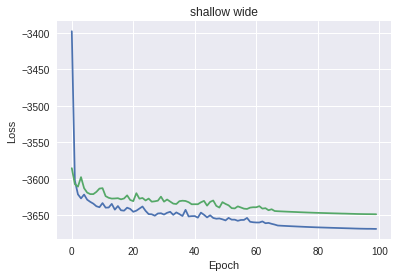

In [23]:
fig, ax = plt.subplots()
#########
ax.plot(History2.history['loss'], marker='', label="Train")
ax.plot(History2.history['val_loss'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_title(r'shallow wide')

Plotting a test set, and observing the results shows very encouraging results, but there are often holes in the edges of the shapes, and the smaller shapes are completely eroded.

Creating data:


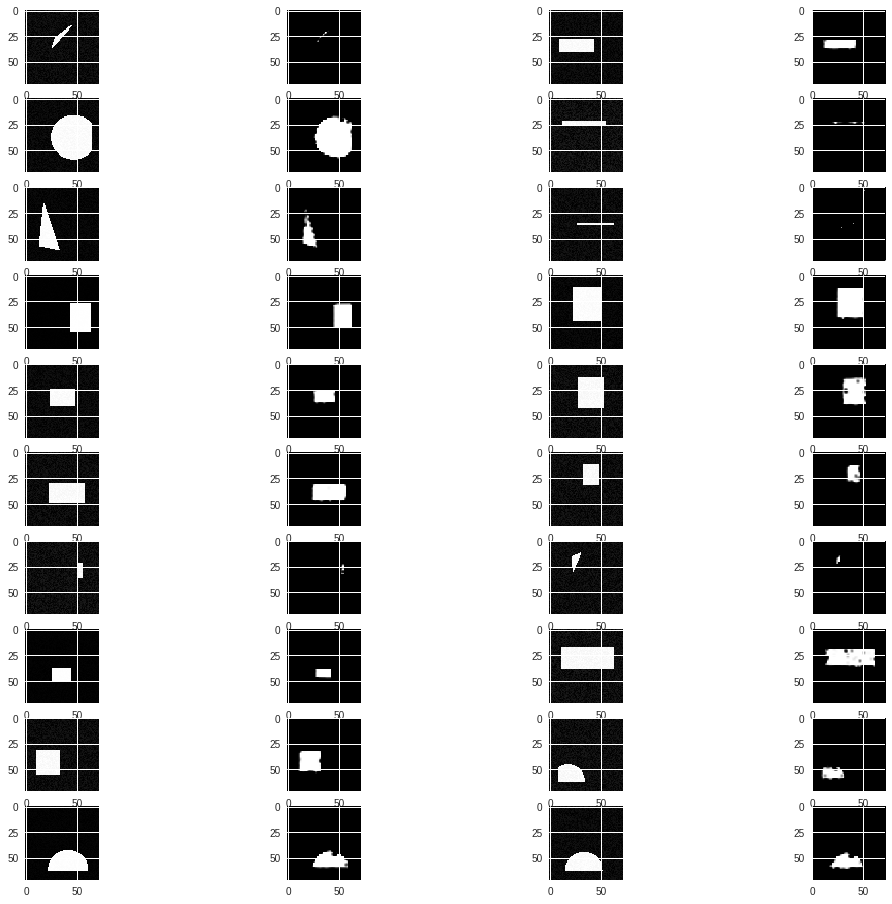

In [24]:
n=20
X_test2, Y_test2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_test2 = X_test2.reshape((n,72,72,1))
Y_test2 = Y_test2.reshape((n,72,72,1))                      

Y_pred2=model2.predict(X_test2)
Y_pred2=Y_pred2.reshape(n,72,72)
X_test2=X_test2.reshape(n,72,72)
visualise_denoising(X_test2,Y_pred2,10)

### A second network

To improve our results and remove these artefacts, we attempt to use a larger network. 

In [29]:
model4 = Sequential()
########
model4.add(Conv2D(32, (3,3), activation='relu', input_shape=(72,72,1), strides=(1,1),padding='same',activity_regularizer=regularizers.l1(0.00001)))
model4.add(MaxPooling2D((2,2), strides=(2,2), padding="same")) #36*36
########
model4.add(Conv2D(32, (3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
model4.add(MaxPooling2D((2,2), strides=(2,2), padding="same")) #18*18
########
model4.add(Conv2D(32,(3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
########
model4.add(UpSampling2D((2,2)))
model4.add(Conv2D(32,(3,3), activation='relu',padding='same', strides=(1,1),activity_regularizer=regularizers.l1(0.00001)))
########
model4.add(UpSampling2D((2,2)))
model4.add(Conv2D(1,(3,3),activation='sigmoid',padding='same', strides=(1,1)))
########
model4.compile(loss='binary_crossentropy',optimizer=adam)
History4=model4.fit(X_train2, Y_train2, validation_split=0.06, batch_size=32, epochs=200, verbose=1)

Train on 4700 samples, validate on 300 samples
Epoch 1/200
4700/4700 [==============================] - 5s 1ms/step - loss: -3458.9829 - val_loss: -3613.0482
Epoch 2/200
4700/4700 [==============================] - 4s 894us/step - loss: -3584.6762 - val_loss: -3583.5954
Epoch 3/200
4700/4700 [==============================] - 4s 877us/step - loss: -3635.8924 - val_loss: -3615.9771
Epoch 4/200
4700/4700 [==============================] - 4s 888us/step - loss: -3653.4908 - val_loss: -3623.0552
Epoch 5/200
4700/4700 [==============================] - 4s 878us/step - loss: -3657.5535 - val_loss: -3622.2026
Epoch 6/200
4700/4700 [==============================] - 4s 883us/step - loss: -3658.5073 - val_loss: -3624.5743
Epoch 7/200
4700/4700 [==============================] - 4s 873us/step - loss: -3656.7397 - val_loss: -3626.2593
Epoch 8/200
4700/4700 [==============================] - 4s 881us/step - loss: -3660.0859 - val_loss: -3628.2057
Epoch 9/200
4700/4700 [============================

Plotting the learning rate we see good learning but the network has mostly converged in 25 epochs. 

Text(0.5,1,'BastieNet')

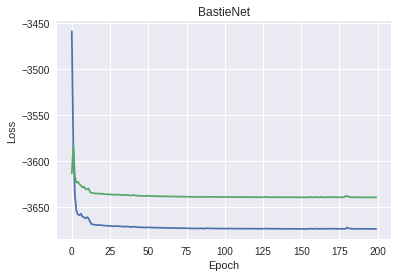

In [30]:
fig, ax = plt.subplots()
#########
ax.plot(History4.history['loss'], marker='', label="Train")
ax.plot(History4.history['val_loss'], marker='', label="Test")
########
ax.set_xlabel(r'Epoch')
ax.set_ylabel(r'Loss')
ax.set_title(r'BastieNet')

The results on actual images are much better and shapes are almost perfectly reconstructed. This is very satisfying.

Creating data:


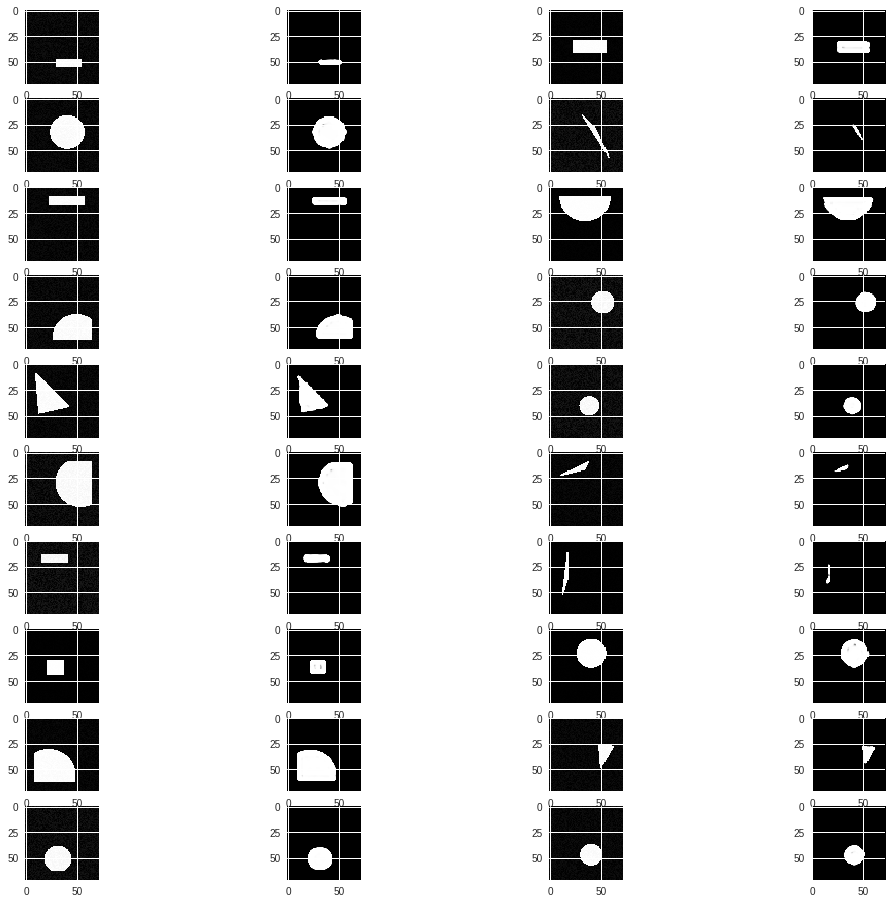

In [31]:
n=20
X_test2, Y_test2 = generate_dataset_denoising(nb_samples=n, free_location=True)
X_test2 = X_test2.reshape((n,72,72,1))
Y_test2 = Y_test2.reshape((n,72,72,1))                      

Y_pred2=model4.predict(X_test2)
Y_pred2=Y_pred2.reshape(n,72,72)
X_test2=X_test2.reshape(n,72,72)
visualise_denoising(X_test2,Y_pred2,10)

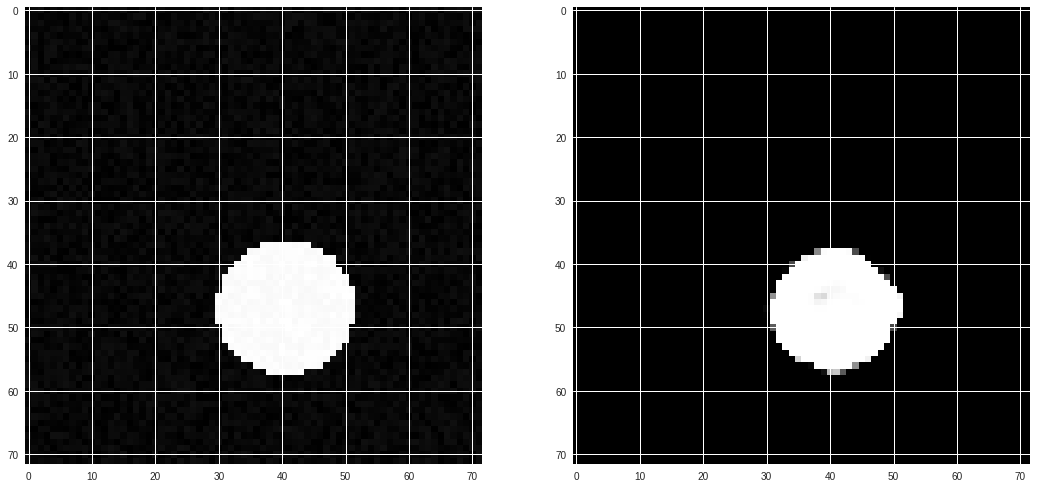

In [32]:
fig, (ax1,ax2) = plt.subplots(figsize=(18, 16),nrows=1,ncols=2)
ax1.imshow(X_test2[19])
ax2.imshow(Y_pred2[19])
plt.show()